# **Tarea 3**

En este taller se trabajará sobre la modificación del juego de escaleras y serpientes del taller anterior. Utilizando el módulo desarrollado en el taller anterior.

Se definen las librerias requeridas

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd

## _Punto 2:_

Escriba un método que implemente el algoritmo Q-Learning. La política de comportamiento debe ser un parámetro de entrada al método.

In [19]:
# Definir posiciones de escaleras y serpientes
escaleras = {8: 26, 21: 82, 43: 77, 50: 91, 54: 93, 66: 87, 62: 96} # modelado de 7 escaleras, la escalera que conecta los estados 80 y 100, por practicidad no se considera al ser ambos estados terminales de victoria.
serpientes = {52: 11, 69: 33, 92: 51, 48: 9, 73: 1, 55: 7, 46: 5, 95: 24, 64: 36, 44: 22, 98: 28, 83: 19, 59: 17} # modelado de serpientes

In [18]:
gamma = 0.9

In [49]:
# informacion inicial que se suministra en el enunciado
tamanoTablero = 100
gana = {80,100} #el usuario ingresa las celdas azules
pierde = {23, 37, 45, 67, 89} #el usuario ingresa la celdas rojas
acciones = [-1,1]
probabilidades = np.array([0.1, 0.2, 0.3, 0.2, 0.1, 0.1]) #se tiene un dado cargado
estados = np.arange(1, tamanoTablero+1) # se configura de esta manera para que vaya desde el 1 al 100
episodios=10000
alpha=0.1

In [11]:
def cargarPoliticaSoft(nombre_archivo="politica_soft.csv", gana=set(), pierde=set()):
    df = pd.read_csv(nombre_archivo)
    politica = {}
    for _, fila in df.iterrows():
        estado = int(fila["Estado"])
        politica[estado] = {
            -1: float(fila["Prob_-1"]),
            1: float(fila["Prob_1"])
        }
    return politica

In [12]:
# Cargar política
politica = cargarPoliticaSoft("politica_soft.csv")

# Convertir a DataFrame para impresión
dfPolitica = pd.DataFrame([
    {
        "Estado": estado,
        "Probabilidad (-1)": probs[-1],
        "Probabilidad (1)": probs[1]
    }
    for estado, probs in politica.items()
])

dfPolitica = dfPolitica.sort_values(by="Estado").reset_index(drop=True)
print(dfPolitica.to_string(index=False))

 Estado  Probabilidad (-1)  Probabilidad (1)
      1           0.272325          0.727675
      2           0.760307          0.239693
      3           0.771892          0.228108
      4           0.187850          0.812150
      5           0.802431          0.197569
      6           0.366485          0.633515
      7           0.096525          0.903475
      8           0.840027          0.159973
      9           0.141050          0.858950
     10           0.455131          0.544869
     11           0.298462          0.701538
     12           0.281620          0.718380
     13           0.615954          0.384046
     14           0.357842          0.642158
     15           0.895493          0.104507
     16           0.488477          0.511523
     17           0.662882          0.337118
     18           0.142967          0.857033
     19           0.352739          0.647261
     20           0.131588          0.868412
     21           0.823579          0.176421
     22   

In [63]:
def transicionRecompensa(estado, accion, dado, escaleras, serpientes):
    nuevoEstado = estado + (accion * dado)

    if nuevoEstado > 100:
        nuevoEstado = 100 - (nuevoEstado - 100)
    elif nuevoEstado == 0:
        nuevoEstado = 1 + (nuevoEstado + 1)
    elif nuevoEstado <= -1:
        nuevoEstado = 1 - (nuevoEstado - 1)

    if nuevoEstado in serpientes:
        nuevoEstado = serpientes[nuevoEstado]
    elif nuevoEstado in escaleras:
        nuevoEstado = escaleras[nuevoEstado]

    if nuevoEstado in pierde:
        recompensa = -100
    elif nuevoEstado in gana:
        recompensa = 100
    else:
        recompensa = -1

    return nuevoEstado, recompensa

In [70]:
def qLearning(piB, episodios, alpha, gamma,
              tamanoTablero, gana, pierde,
              escaleras, serpientes, probabilidades,
              transicionFunc):
    
    Q = defaultdict(lambda: {-1: 0.0, 1: 0.0})
    historial = []

    for ep in range(episodios):
        estado = 1

        while estado not in gana and estado not in pierde:
            acciones = piB[estado]
            listaAcciones = list(acciones.keys())
            listaProbs = list(acciones.values())
            accion = np.random.choice(listaAcciones, p=listaProbs)

            dado = np.random.choice(np.arange(1, 7), p=probabilidades)
            nuevoEstado, recompensa = transicionFunc(
                estado, accion, dado, escaleras, serpientes)

            maxQNuevo = max(Q[nuevoEstado].values()) if nuevoEstado not in gana and nuevoEstado not in pierde else 0
            Q[estado][accion] += alpha * (recompensa + gamma * maxQNuevo - Q[estado][accion])

            estado = nuevoEstado

        # Guardar el valor Q máximo desde el estado inicial al final del episodio
        maxQInicio = max(Q[1].values())
        historial.append(maxQInicio)

    politicaOptima = {}
    for s in range(1, tamanoTablero + 1):
        if s in gana or s in pierde:
            continue
        acciones = Q[s]
        mejorAccion = max(acciones, key=acciones.get)
        politicaOptima[s] = mejorAccion

    return Q, politicaOptima, historial

In [71]:
# Ejecutar Q-learning
Q, politicaOptima, historialQ = qLearning(politica, episodios, alpha, gamma, tamanoTablero, gana, pierde, escaleras, serpientes, probabilidades, transicionFunc=transicionRecompensa)

In [72]:
def verificarOptimalidad(politica, Q, estados, gana, pierde):
    resultados = []

    for s in estados:
        if s in gana or s in pierde:
            continue

        accionesQ = Q[s]
        accionOptimaQ = max(accionesQ, key=accionesQ.get)
        accionPi = politica.get(s, None)

        resultados.append({
            'Estado': s,
            'Acción política aprendida': accionPi,
            'Acción óptima según Q': accionOptimaQ,
            '¿Es óptima?': accionPi == accionOptimaQ
        })

    dfComparacion = pd.DataFrame(resultados)
    esOptima = dfComparacion['¿Es óptima?'].all()

    return dfComparacion, esOptima

In [73]:
Q, politicaOptima, _ = qLearning(politica, episodios, alpha, gamma, tamanoTablero, gana, pierde, escaleras, serpientes, probabilidades, transicionFunc=transicionRecompensa)

In [74]:
dfCheck, esOptima = verificarOptimalidad(politicaOptima, Q, estados, gana, pierde)
display(dfCheck)
print("¿La política aprendida es óptima respecto a Q?", esOptima)

,Estado,Acción política aprendida,Acción óptima según Q,¿Es óptima?
0,1,1,1,True
1,2,1,1,True
2,3,1,1,True
3,4,1,1,True
4,5,1,1,True
...,...,...,...,...
88,95,-1,-1,True
89,96,1,1,True
90,97,1,1,True
91,98,-1,-1,True


¿La política aprendida es óptima respecto a Q? True


In [75]:
dfCheck, esOptima = verificarOptimalidad(politicaOptima, Q, estados, gana, pierde)

In [78]:
def visualizarPoliticaConErrores(politicaOptima, dfCheck, gana, pierde):
    tablero = np.empty((10, 10), dtype=object)

    # Crear conjunto de estados con error de optimalidad
    estadosErroneos = set(dfCheck[dfCheck["¿Es óptima?"] == False]["Estado"])

    for i in range(10):
        for j in range(10):
            # Zig-zag
            if i % 2 == 0:
                estado = i * 10 + j + 1
            else:
                estado = i * 10 + (10 - j)

            if estado in gana:
                simbolo = "🎯"
            elif estado in pierde:
                simbolo = "💀"
            elif estado in estadosErroneos:
                simbolo = "❌"
            else:
                accion = politicaOptima.get(estado, "")
                if accion == -1:
                    simbolo = "⬅️"
                elif accion == 1:
                    simbolo = "➡️"
                else:
                    simbolo = ""

            tablero[9 - i, j] = simbolo

    columnas = [f"C{j+1}" for j in range(10)]
    indices = [f"F{10-i}" for i in range(10)]
    dfTableroErrores = pd.DataFrame(tablero, columns=columnas, index=indices)

    return dfTableroErrores

In [80]:
dfTableroErrores = visualizarPoliticaConErrores(
    politicaOptima, dfCheck, gana, pierde
)
display(dfTableroErrores)

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10
F10,🎯,⬅️,⬅️,➡️,➡️,⬅️,➡️,➡️,⬅️,➡️
F9,⬅️,⬅️,⬅️,⬅️,⬅️,⬅️,⬅️,⬅️,💀,⬅️
F8,🎯,➡️,➡️,➡️,➡️,➡️,➡️,⬅️,➡️,➡️
F7,➡️,⬅️,⬅️,⬅️,⬅️,⬅️,💀,➡️,⬅️,➡️
F6,➡️,⬅️,➡️,➡️,➡️,⬅️,⬅️,⬅️,⬅️,⬅️
F5,➡️,⬅️,⬅️,⬅️,💀,⬅️,➡️,⬅️,➡️,⬅️
F4,➡️,➡️,➡️,💀,⬅️,⬅️,⬅️,⬅️,⬅️,⬅️
F3,⬅️,⬅️,💀,⬅️,⬅️,➡️,➡️,➡️,⬅️,⬅️
F2,⬅️,⬅️,➡️,➡️,➡️,➡️,➡️,➡️,➡️,➡️
F1,➡️,➡️,➡️,➡️,➡️,➡️,➡️,⬅️,➡️,➡️


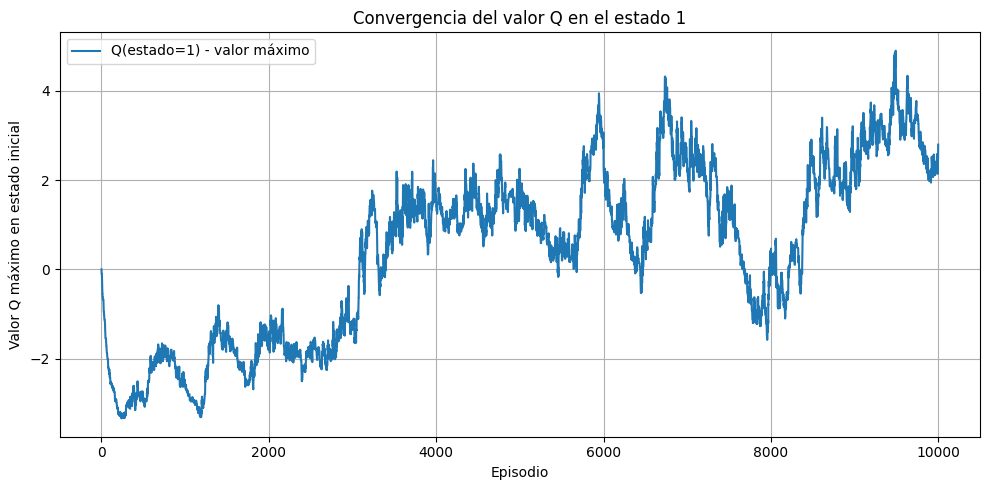

In [61]:
plt.figure(figsize=(10, 5))
plt.plot(historialQ, label="Q(estado=1) - valor máximo")
plt.xlabel("Episodio")
plt.ylabel("Valor Q máximo en estado inicial")
plt.title("Convergencia del valor Q en el estado 1")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [81]:
def visualizarPoliticaTablero(politicaOptima, gana, pierde):
    tablero = np.empty((10, 10), dtype=object)

    for i in range(10):
        for j in range(10):
            # Zig-zag del tablero
            if i % 2 == 0:
                estado = i * 10 + j + 1
            else:
                estado = i * 10 + (10 - j)

            # Determinar símbolo para cada casilla
            if estado in gana:
                simbolo = "🎯"
            elif estado in pierde:
                simbolo = "💀"
            else:
                accion = politicaOptima.get(estado, "")
                if accion == -1:
                    simbolo = "⬅️"
                elif accion == 1:
                    simbolo = "➡️"
                else:
                    simbolo = ""

            tablero[9 - i, j] = simbolo  # invertir verticalmente

    columnas = [f"C{j+1}" for j in range(10)]
    indices = [f"F{10-i}" for i in range(10)]
    dfTablero = pd.DataFrame(tablero, columns=columnas, index=indices)

    return dfTablero

In [83]:
# Visualizar política óptima en forma de tablero
dfPoliticaTablero = visualizarPoliticaTablero(politicaOptima, gana, pierde)
display(dfPoliticaTablero)

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10
F10,🎯,⬅️,⬅️,➡️,➡️,⬅️,➡️,➡️,⬅️,➡️
F9,⬅️,⬅️,⬅️,⬅️,⬅️,⬅️,⬅️,⬅️,💀,⬅️
F8,🎯,➡️,➡️,➡️,➡️,➡️,➡️,⬅️,➡️,➡️
F7,➡️,⬅️,⬅️,⬅️,⬅️,⬅️,💀,➡️,⬅️,➡️
F6,➡️,⬅️,➡️,➡️,➡️,⬅️,⬅️,⬅️,⬅️,⬅️
F5,➡️,⬅️,⬅️,⬅️,💀,⬅️,➡️,⬅️,➡️,⬅️
F4,➡️,➡️,➡️,💀,⬅️,⬅️,⬅️,⬅️,⬅️,⬅️
F3,⬅️,⬅️,💀,⬅️,⬅️,➡️,➡️,➡️,⬅️,⬅️
F2,⬅️,⬅️,➡️,➡️,➡️,➡️,➡️,➡️,➡️,➡️
F1,➡️,➡️,➡️,➡️,➡️,➡️,➡️,⬅️,➡️,➡️
